In [1]:
#nathan's 3060ish card
!nvidia-smi

Sun Mar  1 01:10:35 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.163.01             Driver Version: 550.163.01     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|


|   0  NVIDIA Graphics Device         Off |   00000000:01:00.0 Off |                  N/A |
|  0%   42C    P8              7W /  170W |     180MiB /  12288MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+------------------------+----------------------+
                                                                                         
+-----------------------------------------------------------------------------------------+
| Processes:                                                                              |
|  GPU   GI   CI        PID   Type   Process name                              GPU Memory |
|        ID   ID                                                               Usage      |
|=========================================================================================|
+---------------------------------------------------------------------------------

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.nn.modules.conv import Conv2d

import pandas as pd

import torchvision
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
SEED=42
torch.manual_seed(SEED)
BATCH_SIZE=32

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# personally i use l(learn) as training data and t(test) as testing data
l_data=FashionMNIST(
    root="data", #download loc
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None,
)

t_data=FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

In [4]:
len(l_data), len(t_data)

(60000, 10000)

In [5]:
img,tag=l_data[0]
#channle * hight * width, tag is the label of the image
img.shape, tag

(torch.Size([1, 28, 28]), 9)

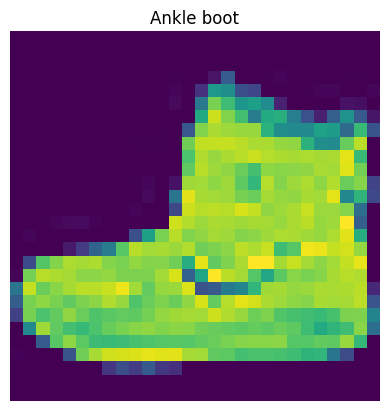

In [6]:
plt.imshow(img.squeeze());
plt.title(l_data.classes[tag]);
plt.axis(False);

In [7]:
len(l_data.classes)

10

In [8]:
l_dl=DataLoader(l_data, batch_size=BATCH_SIZE, shuffle=True)
t_dl=DataLoader(t_data, batch_size=BATCH_SIZE, shuffle=False)

In [9]:
class MLP(nn.Module):
    def __init__(self, in_shape: tuple, out_channels: int, hidden_units: int):
        super().__init__()
        # Assuming input image size is 28x28 based on original model comments
        input_size = 1
        for dim in in_shape:
            input_size *= dim
        
        self.fc_block_1 = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU()
        )
        self.fc_block_2 = nn.Sequential(
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU()
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),  # In case input isn't already flat, but after blocks it's 1D
            nn.Linear(in_features=hidden_units, out_features=out_channels)
        )
    
    def forward(self, x):
        x = nn.Flatten(start_dim=1)(x)  # Flatten at the start
        x = self.fc_block_1(x)
        x = self.fc_block_2(x)
        x = self.classifier(x)
        return x

In [11]:
model=MLP(in_shape=l_data[0][0].shape, out_channels=len(l_data.classes), hidden_units=10).to(device)
model

MLP(
  (fc_block_1): Sequential(
    (0): Linear(in_features=784, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
  )
  (fc_block_2): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [12]:
def train_loop(model:nn.Module, train_dataloader:DataLoader, test_dataloader:DataLoader, optimizer, loss_fn, epochs:int, device):
    '''Train and test a PyTorch model.'''
    loss_fn=loss_fn.to(device)
    for epoch in range(epochs):

        # batch training
        model.train()
        l_loss=0
        for batch, (X,y) in enumerate(train_dataloader):
            X,y=X.to(device),y.to(device)
            # forward pass + compute the loss
            loss=loss_fn(model(X),y)
            l_loss+=loss#.item()

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()
        l_loss/=len(train_dataloader)
        
        # batch testing
        model.eval()
        t_loss=0
        with torch.inference_mode():
            for batch, (X,y) in enumerate(test_dataloader):
                X,y=X.to(device),y.to(device)
                t_loss+=loss_fn(model(X),y).item()
        t_loss/=len(test_dataloader)
        # compute accuracy
        t_acc=0
        with torch.inference_mode():
            for batch, (X,y) in enumerate(test_dataloader):
                X,y=X.to(device),y.to(device)
                t_acc+=(model(X).argmax(dim=1)==y).sum().item()
        t_acc/=len(test_dataloader.dataset)
        print(f"Epoch: {epoch} | Train loss: {l_loss} | Test loss: {t_loss} | Test accuracy: {t_acc}")

In [13]:
train_loop(model=model,
           train_dataloader=l_dl,
           test_dataloader=t_dl,
           optimizer=torch.optim.SGD(model.parameters(), lr=0.1),
           loss_fn=nn.CrossEntropyLoss(),
           epochs=16,
           device=device)

Epoch: 0 | Train loss: 1.0087542533874512 | Test loss: 0.7690818698261492 | Test accuracy: 0.7113
Epoch: 1 | Train loss: 0.5730246901512146 | Test loss: 0.5427424902447496 | Test accuracy: 0.803
Epoch: 2 | Train loss: 0.5132648348808289 | Test loss: 0.5114819959234506 | Test accuracy: 0.817
Epoch: 3 | Train loss: 0.48512300848960876 | Test loss: 0.48105967692292917 | Test accuracy: 0.8254
Epoch: 4 | Train loss: 0.4637002646923065 | Test loss: 0.49749124868990136 | Test accuracy: 0.8236
Epoch: 5 | Train loss: 0.45573756098747253 | Test loss: 0.4722366779090497 | Test accuracy: 0.8365
Epoch: 6 | Train loss: 0.4428172707557678 | Test loss: 0.4815007394161849 | Test accuracy: 0.8344
Epoch: 7 | Train loss: 0.4383523166179657 | Test loss: 0.4818096158508295 | Test accuracy: 0.8336
Epoch: 8 | Train loss: 0.4287034571170807 | Test loss: 0.47066869289159013 | Test accuracy: 0.8344
Epoch: 9 | Train loss: 0.4224769175052643 | Test loss: 0.4630291180107921 | Test accuracy: 0.8445
Epoch: 10 | Train

In [14]:
model=MLP(in_shape=l_data[0][0].shape, out_channels=len(l_data.classes), hidden_units=10).to(device)
train_loop(model=model,
           train_dataloader=l_dl,
           test_dataloader=t_dl,
           optimizer=torch.optim.SGD(model.parameters(), lr=0.05),
           loss_fn=nn.CrossEntropyLoss(),
           epochs=32,
           device=device)

Epoch: 0 | Train loss: 1.203118085861206 | Test loss: 0.7180159836531447 | Test accuracy: 0.7089
Epoch: 1 | Train loss: 0.6333799958229065 | Test loss: 0.6413584506740204 | Test accuracy: 0.7678
Epoch: 2 | Train loss: 0.536022961139679 | Test loss: 0.5849575855480597 | Test accuracy: 0.7881
Epoch: 3 | Train loss: 0.49475640058517456 | Test loss: 0.6187629465953991 | Test accuracy: 0.7798
Epoch: 4 | Train loss: 0.4711295962333679 | Test loss: 0.4777387726706819 | Test accuracy: 0.8247
Epoch: 5 | Train loss: 0.4525030255317688 | Test loss: 0.4789181592079778 | Test accuracy: 0.8325
Epoch: 6 | Train loss: 0.43816569447517395 | Test loss: 0.4745125968378192 | Test accuracy: 0.8298
Epoch: 7 | Train loss: 0.4268229007720947 | Test loss: 0.47839626660362217 | Test accuracy: 0.8318
Epoch: 8 | Train loss: 0.41749638319015503 | Test loss: 0.4726346643111957 | Test accuracy: 0.8329
Epoch: 9 | Train loss: 0.41134700179100037 | Test loss: 0.46560380205559654 | Test accuracy: 0.8307
Epoch: 10 | Trai

In [15]:
model.eval()
preds=[]
with torch.inference_mode():
    for batch, (X,y) in enumerate(t_dl):
        X,y=X.to(device),y.to(device)
        preds.append(model(X).argmax(dim=1))
preds=torch.cat(preds)
preds

tensor([9, 2, 1,  ..., 8, 1, 5], device='cuda:0')

In [16]:
cm=ConfusionMatrix(task='multiclass',num_classes=len(l_data.classes))
cm_tensor=cm(preds=preds.cpu(),
                       target=t_data.targets)
cm_tensor

tensor([[846,   0,  14,  40,   2,   3,  90,   0,   5,   0],
        [  3, 959,   5,  26,   3,   0,   4,   0,   0,   0],
        [ 16,   0, 851,   7,  59,   1,  66,   0,   0,   0],
        [ 48,   7,  14, 855,  41,   1,  30,   0,   4,   0],
        [  0,   2, 216,  34, 696,   0,  52,   0,   0,   0],
        [  4,   1,   0,   0,   0, 914,   0,  44,   6,  31],
        [197,   1, 146,  29,  82,   1, 540,   0,   4,   0],
        [  0,   0,   0,   0,   0,  19,   0, 894,   0,  87],
        [  5,   0,  10,   7,   6,   8,  52,   5, 906,   1],
        [  0,   0,   0,   0,   0,  10,   1,  19,   0, 970]])

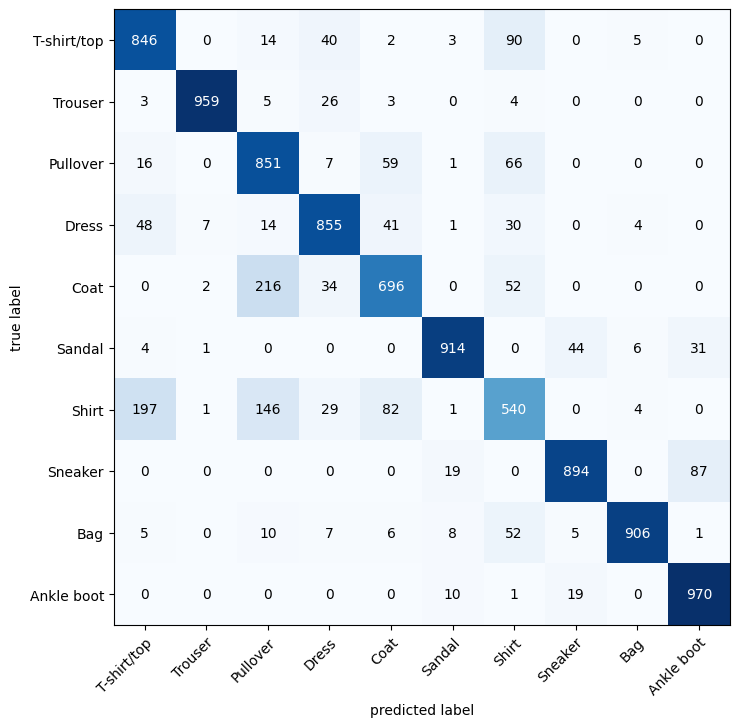

In [17]:
fig,ax=plot_confusion_matrix(
    conf_mat=cm_tensor.numpy(),
    class_names=l_data.classes,
    figsize=(8,8)
)